# Interpolation and Extrapolation with Bayesian last layer

In this notebook, we create the results shown in Figure 2 and 3 of the paper.

In [19]:
# Choose TRUE or FALSE whether to export figures
export_figures = False

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import importlib
import sys
import copy
import pickle

# Matplotlib configuration
execfile('../Plots/config_mpl.py')

sys.path.append('../bll/')

import bayesianlastlayer as bll
import tools

importlib.reload(bll)
importlib.reload(tools)

<module 'tools' from '/Users/felixfiedler/Documents/git_repos/2022_Paper_BLL_LML/Fundamentals/../bll/tools.py'>

# Get data and scaler
- Create training data (3 samples)
- Create true data (100 samples)
- Initialize scaler object

In [2]:
seed = 42

train = tools.get_data(3,[.2,.8], x_type='linear', function_type=5, sigma=0, dtype='float32', random_seed=seed)
true = tools.get_data(300,[0,1], function_type=5, sigma=0, dtype='float32', random_seed=seed)

scaler  = tools.Scaler(*train)
train_scaled = scaler.scale(*train)


# Initialize and train neural network 


In [3]:
save_name_bll = 'results/01_Inter_vs_Extrapolation.pkl'
load_save_model = False

if not load_save_model:
    # Fix seeds
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model_input = keras.Input(shape=(train[0].shape[1],))

    # Hidden units
    architecture = [
        (keras.layers.Dense, {'units': 3, 'activation': 'tanh', 'name': '01_dense'}),
        (keras.layers.Dense, {'units': 2, 'activation': 'linear', 'name': '02_dense'}),
        (keras.layers.Dense, {'name': 'output', 'units': train[1].shape[1]})
    ]

    # Get layers and outputs:
    model_layers, model_outputs = tools.DNN_from_architecture(model_input, architecture)
    joint_model = keras.Model(model_input, [model_outputs[-2], model_outputs[-1]])

    # Get bll model
    bllmodel = bll.BayesianLastLayer(joint_model, scaler)

    #Prepare training
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

    #Setup training:
    bllmodel.setup_training(optimizer)

    #Train
    bllmodel.fit(*train, epochs=5000, verbose=True)

    #Save model
    bllmodel.save(save_name_bll)
else:
    # Unpickle
    with open(save_name_bll, 'rb') as f:
        bllmodel = pickle.load(f)

    joint_model = bllmodel.joint_model

2022-12-20 15:05:31.109961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Print information about the trained model

In [4]:
print(bllmodel)

BayesianLastLayer
----------------
State:
- setup_training = False
- prepare_prediction = True
- n_x   = 1
- n_phi = 3
- n_y   = 1
Results:
- train_lml   = [-1.228]
- log_alpha   = [7.201]
- log_sigma_e = [-5.903]



# Investigation 1: Investigate the effect of $\alpha$ on the log-marginal likelihood (LML) and the log-predictive density (LPD)

This is the second step of algorithm 1 in the paper and we produce here the results shown in Figure 3.

In [8]:
bll_log_alpha_true = bllmodel.grid_search_alpha(*true, rel_range=[-5,20], scores=['pd', 'lml', 'lpd'], samples = 200, max_cond=1e12)
bll_log_alpha_train = bllmodel.grid_search_alpha(*train, rel_range=[-5,20], scores=['pd', 'lml', 'lpd'], samples = 200, max_cond=1e12)

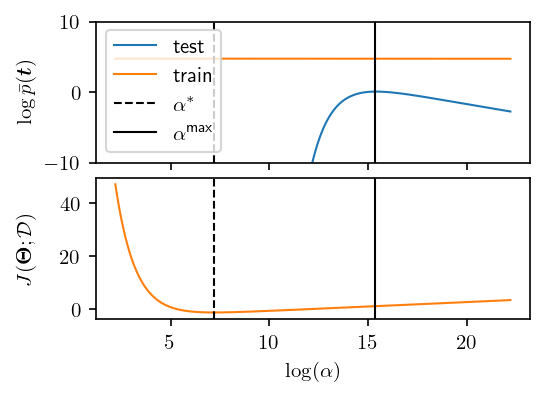

In [16]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(3.49, 2.5), dpi=150)

ax[0].plot(bll_log_alpha_true['log_alpha'], bll_log_alpha_true['lpd'], color=color[0], label='test')
ax[0].plot(bll_log_alpha_train['log_alpha'], bll_log_alpha_train['lpd'], color=color[1], label='train')

ax[0].set_ylim(-10,10)

ax[1].plot(bll_log_alpha_train['log_alpha'], bll_log_alpha_train['lml'], color=color[1], label='train')

ax[0].axvline(bllmodel.log_alpha.numpy(), color='k', linestyle='--', label=r'$\alpha^*$')
ax[1].axvline(bllmodel.log_alpha.numpy(), color='k', linestyle='--', label=r'$\alpha^*$')

logprob_alpha_max = bll_log_alpha_true['log_alpha'][np.argmax(bll_log_alpha_true['lpd'])]
ax[0].axvline(logprob_alpha_max, color='k', linestyle='-', label=r'$\alpha^{\text{max}}$')
ax[1].axvline(logprob_alpha_max, color='k', linestyle='-')

ax[0].legend(loc=3)
ax[1].set_xlabel(r'$\log(\alpha)$')
ax[0].set_ylabel(r'$\log\bar p(\vt)$')
ax[1].set_ylabel(r'$J(\sTheta; \gD)$')


fig.align_labels()
fig.tight_layout(pad=.2)

if export_figures:
    name = 'Funda_08_logprob_lmlh_depence_alpha.pgf'
    fig.savefig(f'../../2022_JPaper_BLL_LogMarginalLikelihood/tex/figures/{name}')

# Investigation 2: Plot predictive distribution and feature space for three values of alpha

We plot the predictive distribution and the feature space for three values of alpha. This produces the results shown in Figure 2 of the paper.

In [17]:
def std_surface(bllmodel, X_train, X_test, ext=0.1):
    """Helper function that computes the standard deviation of the predictive distribution for a grid of points in the feature space. 
    """

    _, phi = bllmodel.mean(X_test)
    phi_min = np.min(phi, axis=0)
    phi_max = np.max(phi, axis=0)
    phi_range = phi_max - phi_min

    phi1_linspace = np.linspace(phi_min[0]-ext*phi_range[0], phi_max[0]+ext*phi_range[0], 100)
    phi2_linspace = np.linspace(phi_min[1]-ext*phi_range[1], phi_max[1]+ext*phi_range[1], 100)

    Phi1_meshgrid, Phi2_meshgrid = np.meshgrid(phi1_linspace, phi2_linspace)

    Phi12_cat = np.concatenate((Phi1_meshgrid.reshape(-1,1), Phi2_meshgrid.reshape(-1,1)), axis=1)
    # Append ones
    Phi12_cat = np.concatenate((Phi12_cat, np.ones((Phi12_cat.shape[0],1))), axis=1)

    bllmodel.prepare_prediction(X_train)
    Sigma_p_bar = bllmodel.Sigma_p_bar

    cov = bllmodel.covariance(Phi12_cat, Sigma_p_bar)
    std = bllmodel.std(cov).reshape(Phi1_meshgrid.shape)

    return Phi1_meshgrid, Phi2_meshgrid, std

/var/folders/rw/cwpn4qds40s2_r4x82fq8sph0000gn/T/ipykernel_917/3359328603.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=.2)


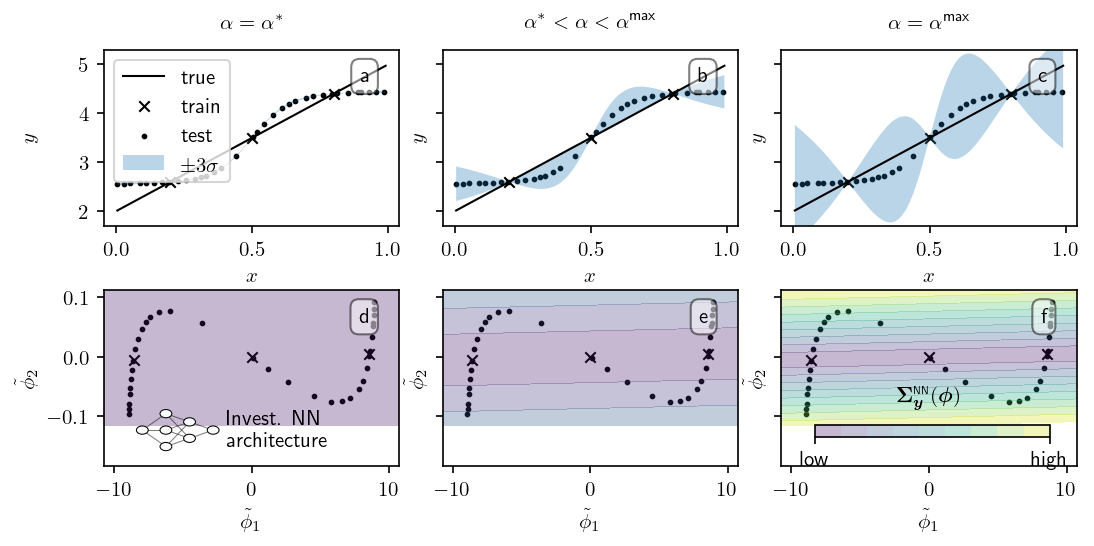

In [21]:
x_test = true[0]

# Plot data
fig, ax = plt.subplots(2, 3, sharex='row', sharey='row', figsize=(7.15, 3.5), dpi=150)

log_alpha_orig = copy.copy(bllmodel.log_alpha.numpy())
_, phi = bllmodel.mean(true[0])
_, Phi = bllmodel.mean(train[0])

levels = np.linspace(0, .5, 10)

alpha_test = [log_alpha_orig, log_alpha_orig+.7*(logprob_alpha_max-log_alpha_orig), logprob_alpha_max]

for i in range(3):
    ax[0,i].plot(true[0], true[1], label='true', color='k', linewidth=1)
    ax[0,i].scatter(train[0], train[1], color='k', marker='x', label=f'train')


    bllmodel.log_alpha = alpha_test[i]
    y_pred, y_std = bllmodel.predict(true[0], uncert_type='std')

    p3sigma = (y_pred+3*y_std).flatten()
    m3sigma=  (y_pred-3*y_std).flatten()

    ax[0,i].scatter(x_test[::9], y_pred[::9], facecolor='k', edgecolor='k', marker='o', label='test', s=3)
    ax[0,i].fill_between(true[0].flatten(), m3sigma, p3sigma, alpha=0.3, label='$\pm3\sigma$')
    ax[0,i].set_xlabel('$x$')
    ax[0,i].set_ylabel('$y$')

    ax[1,i].scatter(phi[::9,0], phi[::9,1], facecolor='k', edgecolor='k', marker='o', label='test', s=3)
    ax[1,i].scatter(Phi[:,0], Phi[:,1], color='k', marker='x', label='train')

    Phi1_meshgrid, Phi2_meshgrid, BLL_std = std_surface(bllmodel, train[0], true[0])
    contours = ax[1,i].contourf(Phi1_meshgrid, Phi2_meshgrid, BLL_std ,alpha=.3, levels=levels)
    ax[1,i].set_xlim(Phi1_meshgrid.min(), Phi1_meshgrid.max())
    ax[1,i].set_xlabel(r'$\tilde\phi_1$')
    ax[1,i].set_ylabel(r'$\tilde\phi_2$')

    # place a text box in upper right in axes coords
    ax[0,i].text(0.9, 0.9, 'abc'[i], transform=ax[0,i].transAxes, verticalalignment='top',horizontalalignment='right', bbox=boxprops)
    ax[1,i].text(0.9, 0.9, 'def'[i], transform=ax[1,i].transAxes, verticalalignment='top',horizontalalignment='right', bbox=boxprops)


# Reset axes limits
data_min = np.min(train[1])
data_max = np.max(train[1])
data_range = data_max - data_min
ax[0,0].set_ylim(data_min - .5*data_range, data_max + .5*data_range)

lim = list(ax[1,0].get_ylim())
lim[0] = lim[0] - 0.3*(lim[1]-lim[0])
ax[1,0].set_ylim(lim)

# Add legend, title etc.
ax[0,0].legend()
ax[0,0].set_title(r'$\alpha = \alpha^*$')
ax[0,1].set_title(r'$\alpha^* < \alpha < \alpha^{\text{max}}$')
ax[0,2].set_title(r'$\alpha = \alpha^{\text{max}}$')

fig.tight_layout(pad=0., w_pad=.4)
fig.align_labels()

cax = ax[1,2].inset_axes([0.1, 0.15, 0.8, 0.1])
cax.set_axis_off()
cax.set_title(r'$\mSigma_\vy^{\NN}(\vphi)$')
cbar = fig.colorbar(contours, ax=cax, orientation='horizontal', fraction=1.0)
cbar.set_ticks([levels[0], levels[-1]])
cbar.set_ticklabels(['low', 'high'])

bllmodel.log_alpha = log_alpha_orig


cax = ax[1,0].inset_axes([0.1, 0.03, 0.30, 0.35])
cax.set_axis_off()
tools.draw_neural_net(cax, 0.1, .9, 0.1, .9, [1,3,2,1], line_width=.5)
cax.text(1.05, .5, 'Invest. NN\narchitecture', verticalalignment='center')


if export_figures:
    name = 'Funda_08_Pred_and_Featurespace_alpha_comparison.pgf'
    fig.savefig(f'../../2022_JPaper_BLL_LogMarginalLikelihood/tex/figures/{name}')